<a href="https://colab.research.google.com/github/dominikstrb/lqg/blob/main/CCN_2022_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lqg==0.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.6 MB/s 
     |████████████████████████████████| 283 kB 11.0 MB/s 
     |████████████████████████████████| 72.0 MB 116 kB/s 
  Created wheel for jax: filename=jax-0.3.15-py3-none-any.whl size=1201920 sha256=5faf56e93e60080849ef7e6519ee7af534eb5795dcbf109c881d6c4f6942aab9
  Stored in directory: /root/.cache/pip/wheels/7b/36/dc/90243142efbc28986784e072b123d4e674dc79edd013ce665b
Successfully built jax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.14+cuda11.cudnn805
    Uninstalling jaxlib-0.3.14+cuda11.cudnn805:
      Successfully uninstalled jaxlib-0.3.14+cuda11.cudnn805
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14


In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

from jax import grad, vmap, jit, random, numpy as jnp

from lqg.model import LQG, Actor, Dynamics, System
from lqg import xcorr

## Quick intro to jax


1. NumPy-like API: `jax.numpy`


In [ ]:
a = jnp.array([[1., 2.],
               [3., 4.]])

a

DeviceArray([[1., 2.],
             [3., 4.]], dtype=float32)

In [ ]:
key = random.PRNGKey(1)
b = random.normal(key, shape=(2, 3))

a @ b

DeviceArray([[ 1.6896877, -0.6240323,  1.5889112],
             [ 4.3366823, -2.2179935,  4.184889 ]], dtype=float32)

2. Automatic differentiation: `grad`

In [ ]:
def f(x):
  return x**2

grad(f)(4.)

DeviceArray(8., dtype=float32, weak_type=True)

3. Easy vectorization: `vmap`

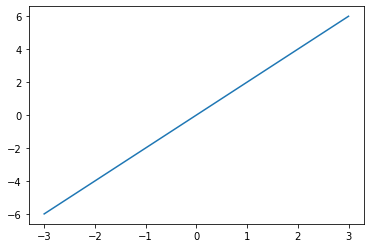

In [ ]:
x = jnp.linspace(-3, 3)
plt.plot(x, vmap(grad(f))(x))

# Putting perception into action: Inverse optimal control for continuous psychophysics

## Modeling a tracking task with LQG control

The LQG control problem is defined by a linear-Gaussian stochastic dynamical system
$$
\mathbf x_{t+1} = A \mathbf x_t + B \mathbf u_t + V \mathbf \epsilon_t, \; \mathbf\epsilon_t \sim \mathcal{N}(0, I),
$$

a linear-Gaussian observation model
$$
\mathbf y_t = C \mathbf x_t + W \mathbf \eta_t, \; \mathbf\eta_t \sim \mathcal{N}(0, I),
$$

and a quadratic cost function

$$
J = \sum_t \mathbf x_t^T Q \mathbf x_t + \mathbf u_t^T R \mathbf u_t.
$$

We start by defining the matrices $A, B, C, V, W, Q, R$ to model a simple position tracking task.

In [ ]:
action_variability = 0.5
sigma_target = 6.
sigma_cursor = 1.
action_cost = .05

dt = 1. / 60.

A = jnp.eye(2)
B = jnp.array([[0.], 
              [dt]])

V = jnp.diag(jnp.array([1., action_variability]))

C = jnp.eye(2)
W = jnp.diag(jnp.array([sigma_target, sigma_cursor]))


Q = jnp.array([[1., -1.],
              [-1., 1]])

R = jnp.eye(1) * action_cost

model = LQG(A, B, C, V, W, Q, R)

Let's simulate some tracking data by applying the Kalman filter and linear-quadratic regular. This is implemented in the method `simulate(rng_key, n, T)`. Since `jax` does not have a global random number generator state, we need to pass a `PRNGKey` object. `n` is the number of trials and `T` is the number of time steps.

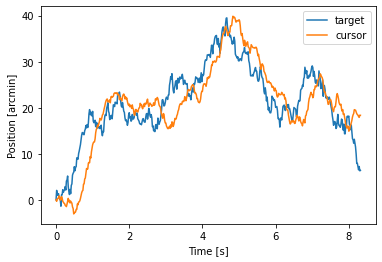

In [ ]:
T = 500
x = model.simulate(random.PRNGKey(0), n=100, T=T)

plt.plot(jnp.arange(T) * dt, x[:, 1, 0], label="target")
plt.plot(jnp.arange(T) * dt, x[:, 1, 1], label="cursor")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Position [arcmin]")
plt.show()

## Cross-correlograms

We can also look at the correlation between the velocities of the target and the cursor at different time lags. This analysis is known as a cross-correlogram (Mulligan et al., 2013).

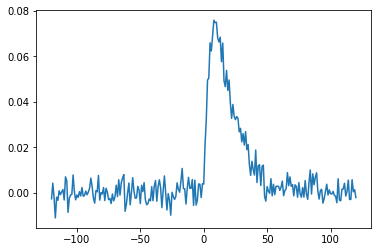

In [ ]:
vels = jnp.diff(x, axis=0)
lags, correls = xcorr(vels[...,1].T, vels[...,0].T, maxlags=120)

plt.plot(lags, correls.mean(axis=0))

## Influence of model parameters

To look a the influence of the different model parameters, we define a class that inherits from the `LQG` base class and defines the matrices given the four parameters.

In [ ]:
class BoundedActor(LQG):
  def __init__(self, 
               sigma_target, 
               action_variability, 
               action_cost, 
               sigma_cursor):
    
    dt = 1. / 60.

    A = jnp.eye(2)
    B = jnp.array([[0.], 
                  [dt]])

    V = jnp.diag(jnp.array([1., action_variability]))

    C = jnp.eye(2)
    W = jnp.diag(jnp.array([sigma_target, sigma_cursor]))


    Q = jnp.array([[1., -1.],
                  [-1., 1]])

    R = jnp.eye(1) * action_cost

    
    super().__init__(A=A, B=B, C=C, V=V, W=W, Q=Q, R=R)

In [ ]:
@jit # jit-compile the simulation part to speed up our interactive widget
def simulate_trajectories(sigma_target,
                          action_cost,
                          action_variability, 
                          sigma_cursor):
  model = BoundedActor(sigma_target=sigma_target, 
                       action_variability=action_variability,
                       action_cost=action_cost, 
                       sigma_cursor=sigma_cursor)

  x = model.simulate(random.PRNGKey(0), n=100, T=500)

  return x

style = {"description_width": "200px"}
layout = {'width': '400px'}

@interact(sigma_target=widgets.FloatLogSlider(min=-1, max=2, value=10., 
                                       style=style, layout=layout,
                                       description="Perceptual uncertainty (target)"), 
          action_cost=widgets.FloatLogSlider(min=-2, max=1, value=1., 
                                   style=style, layout=layout,
                                   description="Behavioral costs"),
          action_variability=widgets.FloatSlider(min=.1, max=2., value=.5, 
                                      style=style, layout=layout,
                                      description="Action variability"),
          sigma_cursor=widgets.FloatLogSlider(min=-1, max=2, value=10., 
                                         style=style, layout=layout,
                                       description="Perceptual uncertainty (cursor)"))
def plot_trajectory(sigma_target, action_cost, action_variability, sigma_cursor):

  x = simulate_trajectories(sigma_target, action_cost, action_variability, sigma_cursor)

  f, ax = plt.subplots(1, 2, figsize=(8., 4.))
  ax[0].plot(jnp.arange(500) / 60, x[:, 0, 0])
  ax[0].plot(jnp.arange(500) / 60, x[:, 0, 1])
  ax[0].set_ylim(-30, 30)
  ax[0].set_title("Trajectory")
  ax[0].set_xlabel("Time [s]")
  ax[0].set_ylabel("Position [arcmin]")

  # cross-correlograms
  vels = jnp.diff(x, axis=0)
  lags, correls = xcorr(vels[...,1].T, vels[...,0].T, maxlags=120)

  ax[1].plot(lags / 60, correls.mean(axis=0))
  ax[1].set_ylim(-.01, .1)
  ax[1].set_title("Cross-correlogram")
  ax[1].set_ylabel("Correlation")
  ax[1].set_xlabel("Time lag [s]")

  f.tight_layout()

interactive(children=(FloatLogSlider(value=10.0, description='Perceptual uncertainty (target)', layout=Layout(…

## Subjective internal models

The dynamical system that defines the experiment (i.e. the target movement) might not be known to the agent. In that case, we can assume that the agent has their own subjective internal model, which may differ from the true model.

For example, the agent could assume that there is a velocity component to the random walk

$$
x_{t+1} = x_t + dt * v_t + \sigma_s * \epsilon_t \\
v_{t+1} = v_t + \sigma_v * \varepsilon_t.
$$

Let's simulate this and compare it to the random walk on position that was used in the experiment.

In [ ]:
@interact(sigma_s=widgets.FloatSlider(min=0., max=2., value=1.,
                                      style=style, layout=layout,
                                       description="Subjective std"), 
          sigma_v=widgets.FloatSlider(min=0., max=2., value=0., 
                                   style=style, layout=layout,
                                   description="Subjective vel std"))
def simulate_random_walks(sigma_s, sigma_v):
  T = 100
  n = 20
  dt = 1. / 60.

  key, key_s, key_v = random.split(random.PRNGKey(123), 3)
  x_true = jnp.cumsum(random.normal(key, shape=(T, n)), axis=0)

  v = jnp.cumsum(random.normal(key_s, shape=(T, n)) * sigma_v, axis=0)
  x = jnp.cumsum(random.normal(key_v, shape=(T, n)) * sigma_s + dt * v, axis=0)

  f, ax = plt.subplots(1, 2, sharey=True, sharex=True)
  ax[0].plot(x_true)
  ax[1].plot(x)
  f.show()

interactive(children=(FloatSlider(value=1.0, description='Subjective std', layout=Layout(width='400px'), max=2…

We now define a class for the subjective actor. We now need to distinguish between the matrices of the actual dynamical system of the experiment and those of the subjective internal model of the agent. This is possible in the `lqg` package by defining a `Dynamics` and an `Actor` object and combining them into a `System`.

In [ ]:
class SubjectiveActor(System):
  def __init__(self, sigma_s, sigma_v):
    dt = 1. / 60.

    # parameters
    action_variability = 0.5
    action_cost = 0.05
    sigma = 6.
    sigma_prop = 3.

    A = jnp.eye(2)
    B = jnp.array([[0.], [dt]])
    V = jnp.diag(jnp.array([1., action_variability]))

    C = jnp.eye(2)
    W = jnp.diag(jnp.array([sigma, sigma_prop]))

    dynamics = Dynamics(A, B, C, V, W)

    # subjective dynamical system parameters
    A_subj = jnp.array([[1., 0., dt], 
                        [0., 1., 0.], 
                        [0., 0., 1.]])
    B_subj = jnp.array([[0.], [dt], [0.]])
    C_subj = jnp.eye(2, 3)
    V_subj = jnp.diag(jnp.array([sigma_s, action_variability, sigma_v]))
    
    # cost function
    Q = jnp.array([[1., -1., 0.],
                [-1., 1., 0.],
                [0., 0., 0.]])

    R = jnp.eye(1) * action_cost

    actor = Actor(A_subj, B_subj, C_subj, V_subj, W, Q, R)

    super().__init__(actor=actor, dynamics=dynamics)

In [ ]:
@jit # jit-compile the simulation part to speed up our interactive widget
def simulate_subjective_actor(sigma_s, sigma_v):

  model = SubjectiveActor(sigma_s, sigma_v)
  x = model.simulate(random.PRNGKey(0), x0=jnp.zeros(2), n=100, T=500)

  return x

@interact(sigma_s=widgets.FloatSlider(min=0., max=2., value=1., 
                                       style=style, layout=layout,
                                       description="Subjective std"), 
          sigma_v=widgets.FloatSlider(min=0., max=2., value=0., 
                                   style=style, layout=layout,
                                   description="Subjective vel std"))
def plot_trajectory(sigma_s, sigma_v):

  x = simulate_subjective_actor(sigma_s, sigma_v)

  f, ax = plt.subplots(1, 2, figsize=(8., 4.))
  ax[0].plot(jnp.arange(500) / 60, x[:, 0, 0])
  ax[0].plot(jnp.arange(500) / 60, x[:, 0, 1])
  ax[0].set_ylim(-30, 30)
  ax[0].set_title("Trajectory")
  ax[0].set_xlabel("Time [s]")
  ax[0].set_ylabel("Position [arcmin]")

  # cross-correlograms
  vels = jnp.diff(x, axis=0)
  lags, correls = xcorr(vels[...,1].T, vels[...,0].T, maxlags=120)

  ax[1].plot(lags / 60, correls.mean(axis=0))
  ax[1].set_ylim(-.03, .1)
  ax[1].set_title("Cross-correlogram")
  ax[1].set_ylabel("Correlation")
  ax[1].set_xlabel("Time lag [s]")

  f.tight_layout()

interactive(children=(FloatSlider(value=1.0, description='Subjective std', layout=Layout(width='400px'), max=2…

## Exercises

### 1. More realistic hand motion model

In our simple model of the tracking task, we have only included the position of the cursor in the state and assumed that the agent directly controls the velocity. A more realistic model might include the velocity in the state and model the agent as exerting a force that indirectly affects the velocity.

In that case, the equations for the position, velocity, and force would be given by:

$$
p_{t+1} = p_t + dt * v_t \\
v_{t+1} = v_t + dt * F_t / m\\
F_{t+1} = (1 - dt / \tau_2) * F_t + u_t,
$$

where $m$ is the mass of the hand and $\tau$ acts as a damping term that prevents large forces.

Implement this more realistic model for the motion of the hand.

### 2. Different target dynamics

In [ ]:
class ExtendedMotionModel(LQG):
  def __init__(self, 
               sigma_target, 
               action_variability, 
               action_cost, 
               sigma_cursor):
    
    dt = 1. / 60. # time constant

    m = 0.5 # mass in kilogramms
    tau = 40 / 1000 # time constant of muscle-like low-pass filter


    A = jnp.array([[1., 0., 0., 0.],
                   [0., 1., dt / m, 0.],
                   [0., 0., 1., dt / m],
                   [0., 0., 0., 1. - dt / tau]])
    B = jnp.array([[0.],
                   [0.], 
                   [0.],  
                  [dt / tau]])

    V = jnp.diag(jnp.array([1., action_variability, 0., 0.]))

    C = jnp.eye(2, 4)
    W = jnp.diag(jnp.array([sigma_target, sigma_cursor]))


    Q = jnp.array([[1., -1., 0., 0.],
                  [-1., 1, 0., 0.],
                   [0., 0., 0., 0.],
                   [0., 0., 0., 0.]])

    R = jnp.eye(1) * action_cost
    
    super().__init__(A=A, B=B, C=C, V=V, W=W, Q=Q, R=R)

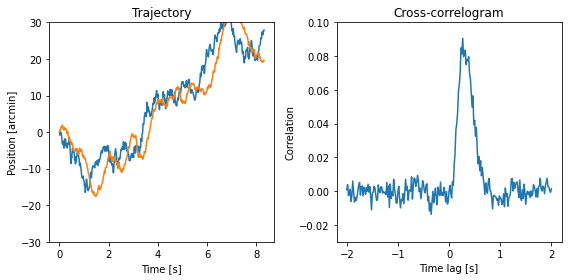

In [ ]:
model = ExtendedMotionModel(sigma_target=6., 
                       action_variability=.5,
                       action_cost=0.005, 
                       sigma_cursor=3.)

x = model.simulate(random.PRNGKey(0), n=100, T=500)

f, ax = plt.subplots(1, 2, figsize=(8., 4.))
ax[0].plot(jnp.arange(500) / 60, x[:, 0, 0])
ax[0].plot(jnp.arange(500) / 60, x[:, 0, 1])
ax[0].set_ylim(-30, 30)
ax[0].set_title("Trajectory")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Position [arcmin]")

# cross-correlograms
vels = jnp.diff(x, axis=0)
lags, correls = xcorr(vels[...,1].T, vels[...,0].T, maxlags=120)

ax[1].plot(lags / 60, correls.mean(axis=0))
ax[1].set_ylim(-.03, .1)
ax[1].set_title("Cross-correlogram")
ax[1].set_ylabel("Correlation")
ax[1].set_xlabel("Time lag [s]")

f.tight_layout()


# Inverse optimal control

## Likelihood function

Text(0.5, 1.0, 'Log likelihood')

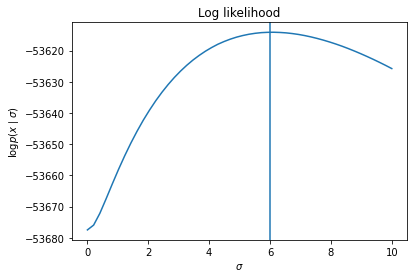

In [ ]:
# simulate some data
x = BoundedActor(sigma_target=6., action_variability=0.5, action_cost=0.5, sigma_cursor=1.).simulate(random.PRNGKey(1), n=50, T=500)

# range of parameter values
sigmas = jnp.linspace(0., 10.)

# likelihood of one parameter, keeping others constant at the true value
likelihood = lambda sigma: BoundedActor(sigma_target=sigma, action_variability=0.5, action_cost=0.5, sigma_cursor=1.).log_likelihood(x).sum()

plt.plot(sigmas, vmap(likelihood)(sigmas))
plt.axvline(6.)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$\log p(x \mid \sigma)$")
plt.title("Log likelihood")

## Bayesian inference with NumPyro

In [ ]:
import numpyro
from numpyro import distributions as dist
from numpyro.infer import NUTS, MCMC
import arviz as az

def lqg_model(x):

  action_variability = numpyro.sample("action_variability", dist.HalfCauchy(1.))
  action_cost = numpyro.sample("action_cost", dist.HalfCauchy(1.))
  sigma_target = numpyro.sample("sigma_target", dist.HalfCauchy(30.))
  sigma_cursor = numpyro.sample("sigma_cursor", dist.HalfCauchy(15.))

  model = BoundedActor(action_variability=action_variability,
                       action_cost=action_cost,
                       sigma_target=sigma_target,
                       sigma_cursor=sigma_cursor)

  # likelihood
  numpyro.sample("x", model.conditional_distribution(x[:-1]),
                  obs=x[1:])

In [ ]:
nuts_kernel = NUTS(lqg_model)

mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), x)

sample: 100%|██████████| 1500/1500 [04:51<00:00,  5.15it/s, 3 steps of size 4.63e-01. acc. prob=0.93]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2491559310>,
      dtype=object)

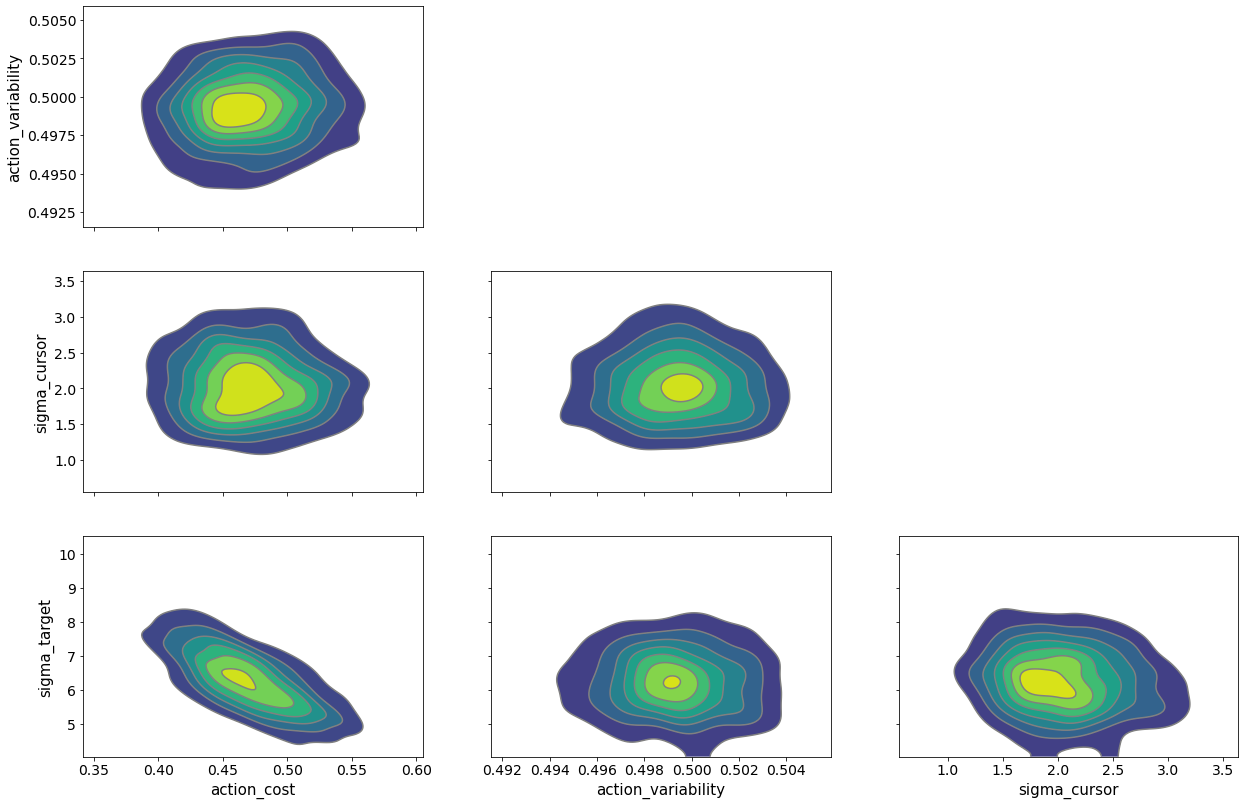

In [46]:
samples = mcmc.get_samples()
az.plot_pair(samples, kind="kde")

In [47]:
summary = az.summary(samples)

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [48]:
model = BoundedActor(**summary["mean"].to_dict())

x, xhat, y, u = model.simulate(random.PRNGKey(0), n=20, T=500, return_all=True)

## Belief tracking

Text(0, 0.5, 'Position [arcmin]')

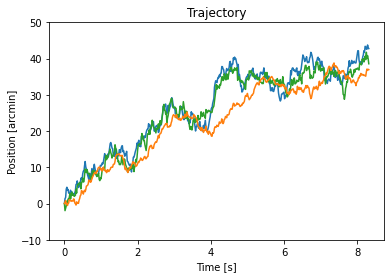

In [49]:
f, ax = plt.subplots()
ax.plot(jnp.arange(500) / 60, x[:, 0, 0])
ax.plot(jnp.arange(500) / 60, xhat[:, 0, 0], color="C2")

ax.plot(jnp.arange(500) / 60, x[:, 0, 1])
ax.set_ylim(-10, 50)
ax.set_title("Trajectory")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position [arcmin]")